visualize_trained_som.ipynb

Creates labeled projections of each dimension of the SOM onto 2d hexagonal meshes. Adjacent hexagons are neighboring in the SOM, their actual separation is not depicted in these maps.

In [1]:
import os
from glob import glob

from astropy.io import fits
from astropy.table import Table, hstack, vstack

import fitsio
from fitsio import FITS

import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured, append_fields

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('mpdg.mplstyle'
)

from matplotlib.patches import Rectangle

In [6]:
folder = '/Users/leo/Projects/mass_profile_dg/saved_SOMs/09Aug24_mag_cut_20p5'
KiDS_predicted = FITS(f'{folder}/predicted_catalog.fits')[1]

codebook = np.load(f'{folder}/SOM_codebook.npy',
                   allow_pickle = True)

labeled_map = np.load(f'{folder}/labeled_map.npy',
                      allow_pickle = True)
labeled_map_values = np.load(f'{folder}/labeled_map_values.npy',
                      allow_pickle = True)
data_bmus = np.load(f'{folder}/data_bmus.npy',
                      allow_pickle = True)
labeling_bmus = np.load(f'{folder}/labeling_bmus.npy',
                      allow_pickle = True)

In [3]:
#set parameters
n_columns      = 48
n_rows         = 48

maptype        = 'toroid'
gridtype       = 'hexagonal'

initialization = 'pca'

neighborhood   = 'gaussian'
std_coeff      = 0.5

verbose        = 2

compactsupport = False

#training parameters
epochs        = 50

radius0       = 0
radiusN       = 1
radiuscooling = 'exponential'

scale0        = 0.25
scaleN        = 0.01
scalecooling  = 'exponential'

In [8]:
# #Load in KiDS data
def load_KiDS_data(path):

    # cat_section = fitsio.read(path, ext = 1)
    cat_section = FITS(path)[1][:]
    
    mag_cut      = cat_section['r_mag'] < 20.5
    redshift_cut = cat_section['redshift'] < 0.4

    cat_section_cut = cat_section[redshift_cut & mag_cut]

    colnames = cat_section.dtype.names
    columns = ['r_mag']
    columns +=[key for key in colnames\
               if key.endswith('col')]
    columns +=['half_light_radius']
    # columns +=['redshift']

    cat_section_selected = cat_section_cut[columns]
    
    coordinate_columns = ['ID', 'KiDS_tile', 'ra', 'dec']
    
    cat_section_coordinates = cat_section_cut[coordinate_columns]

    return cat_section_selected, cat_section_coordinates

In [9]:
training_data_secs_path = '/Users/leo/Projects/mass_profile_dg/data_products/SOM_catalogs/KiDS/KiDS_SOM_panchrom_07Aug24/KiDS_SOM_panchrom_07Aug24'
training_data_sec1,  _  = load_KiDS_data(f'{training_data_secs_path}_sec1.fits')

In [29]:
training_data_names = training_data_sec1.dtype.names
training_data_names = np.append(training_data_names, 'BPZ')

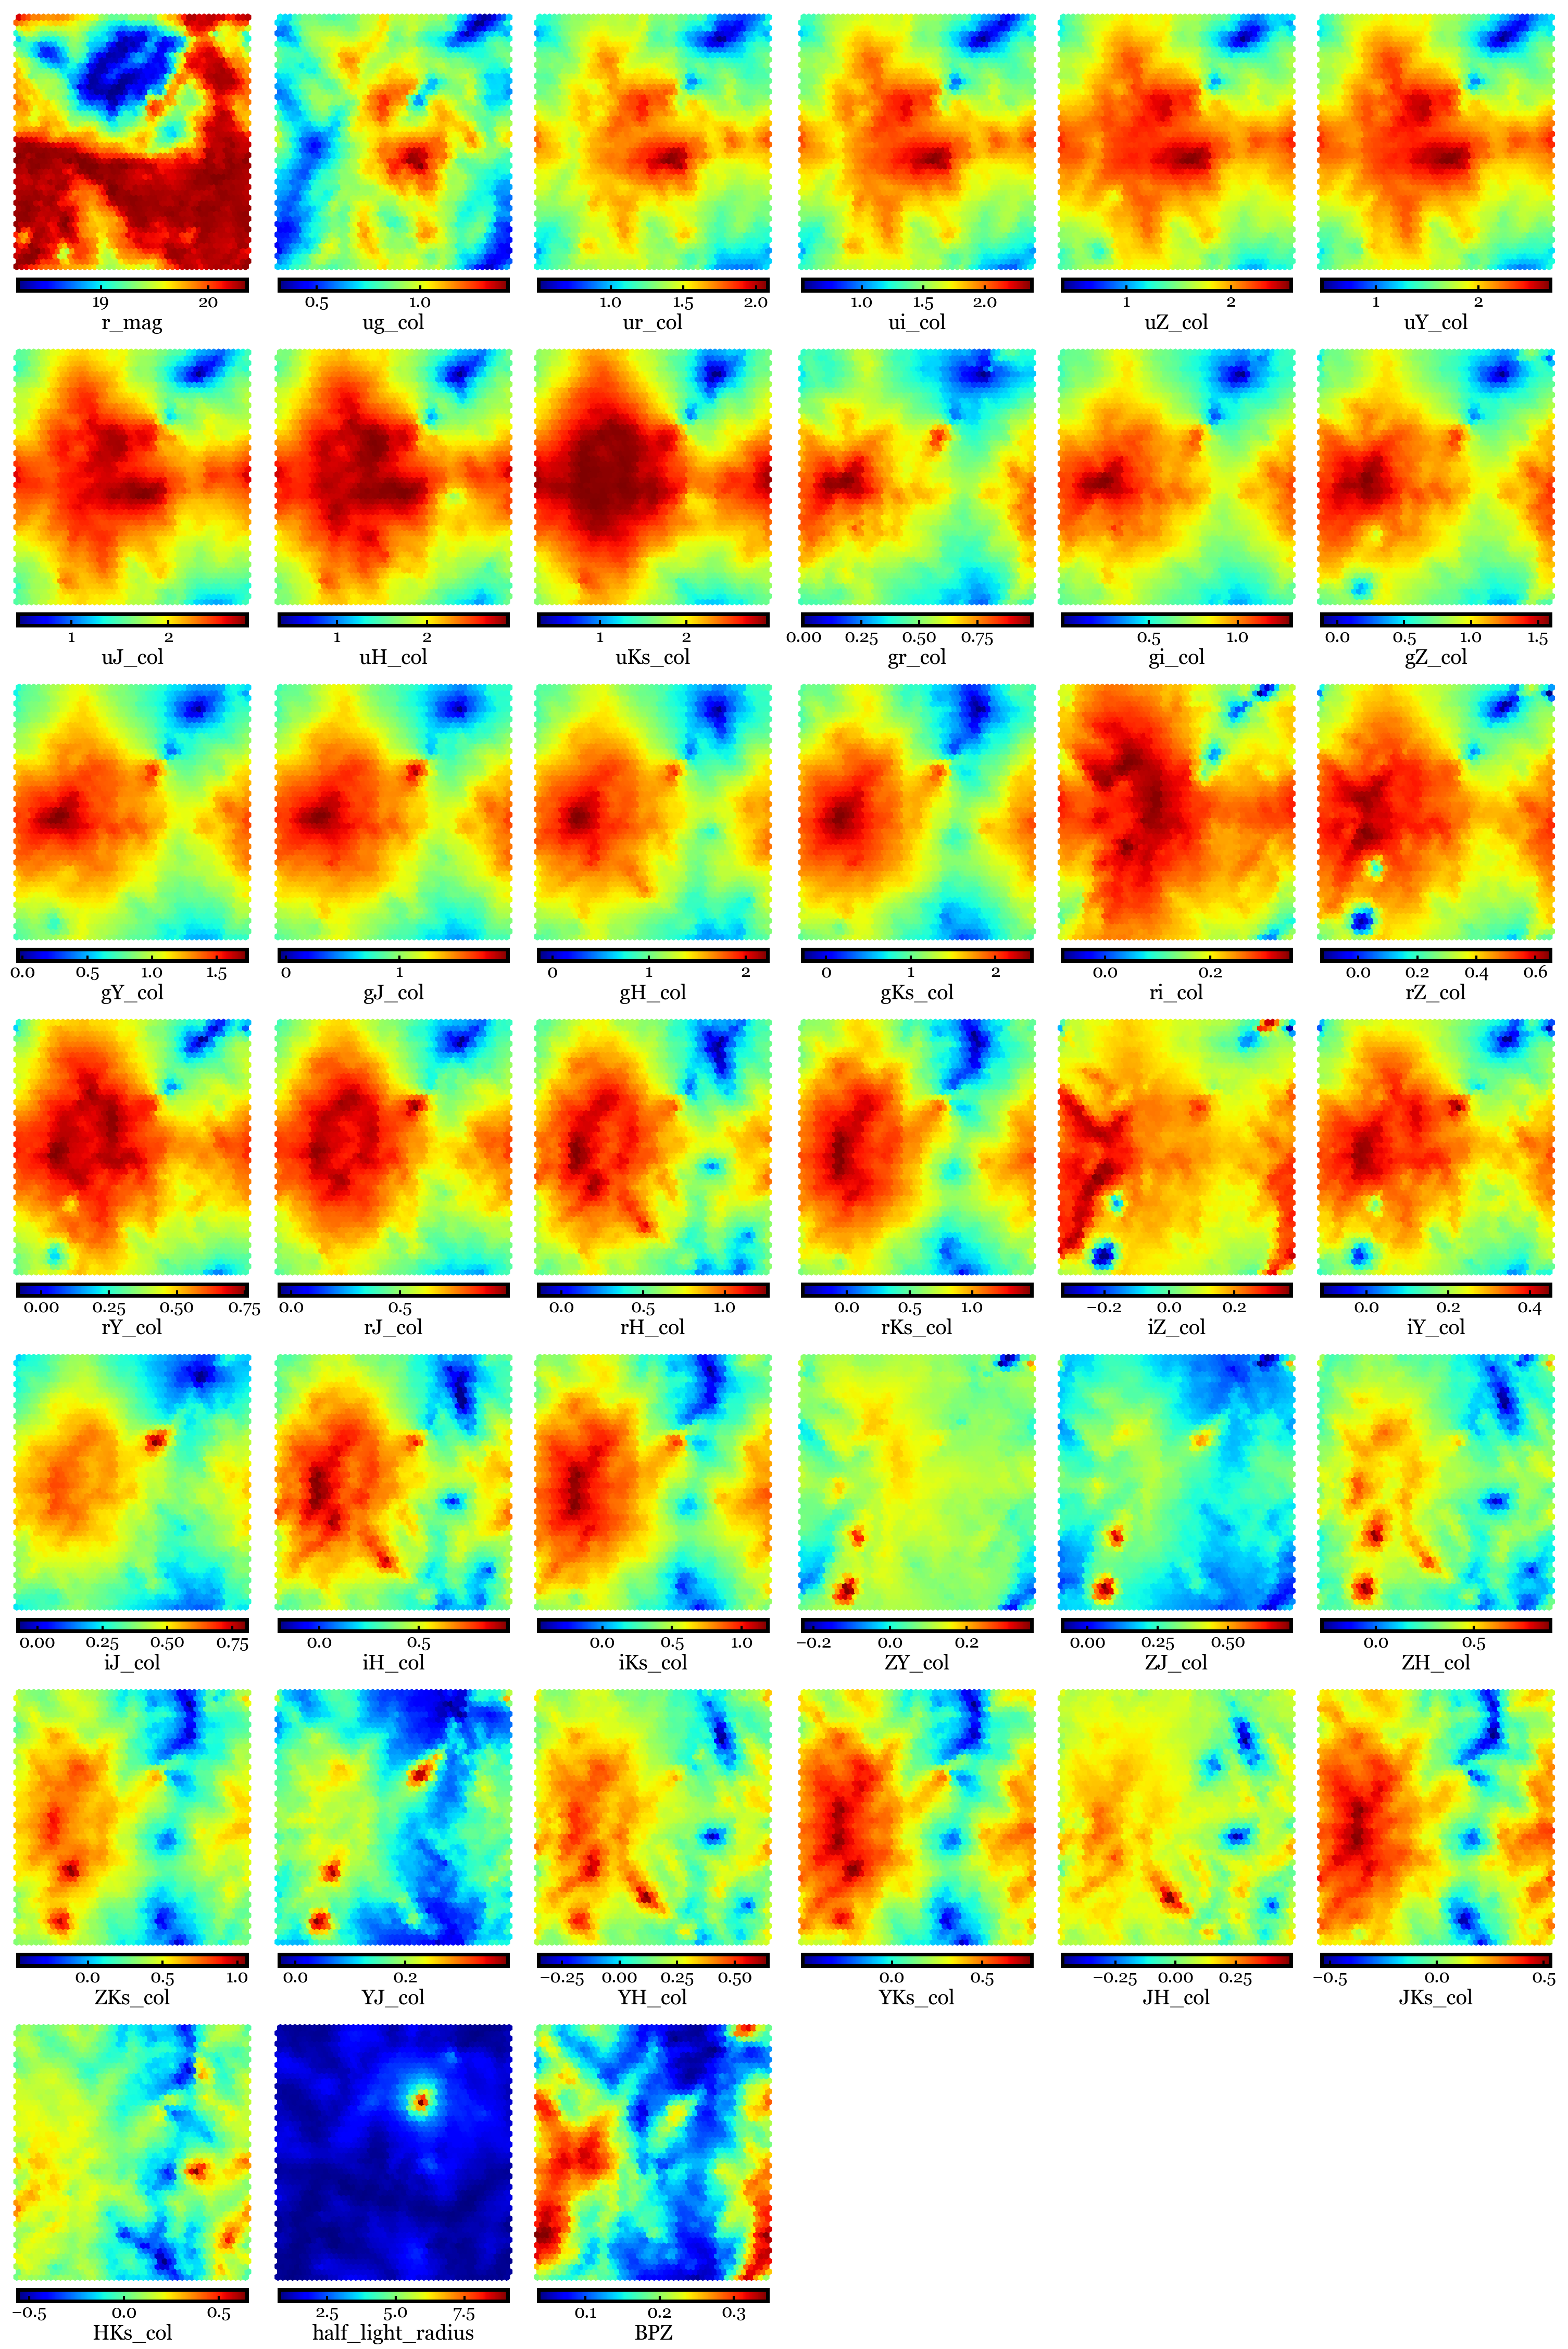

In [40]:
#Visualize trained SOM
hexmesh = np.meshgrid(np.linspace(0, n_rows - 1, n_rows),
                       np.linspace(0, n_columns - 1, n_columns))

hexmesh[0][1::2] += 1/2

fig = plt.figure(figsize = (30, 45), constrained_layout = True)
transposed_codebook = np.transpose(codebook, [1, 0, 2])

n_row = 7
n_col = 6

for i in range(n_row):
    for j in range(n_col):

        ax = fig.add_subplot(n_row, n_col, i*n_col + j + 1)

        try:
            map = ax.scatter(*hexmesh, c = transposed_codebook[..., i*n_col + j], marker = 'h', cmap = 'jet', s = 95)
            fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = training_data_names[i*n_col + j], shrink = 0.9, pad = 0)
        except: pass
        ax.axis('off')

fig.savefig(f'/Users/leo/Projects/senior_thesis/vert_trained_SOM.png')

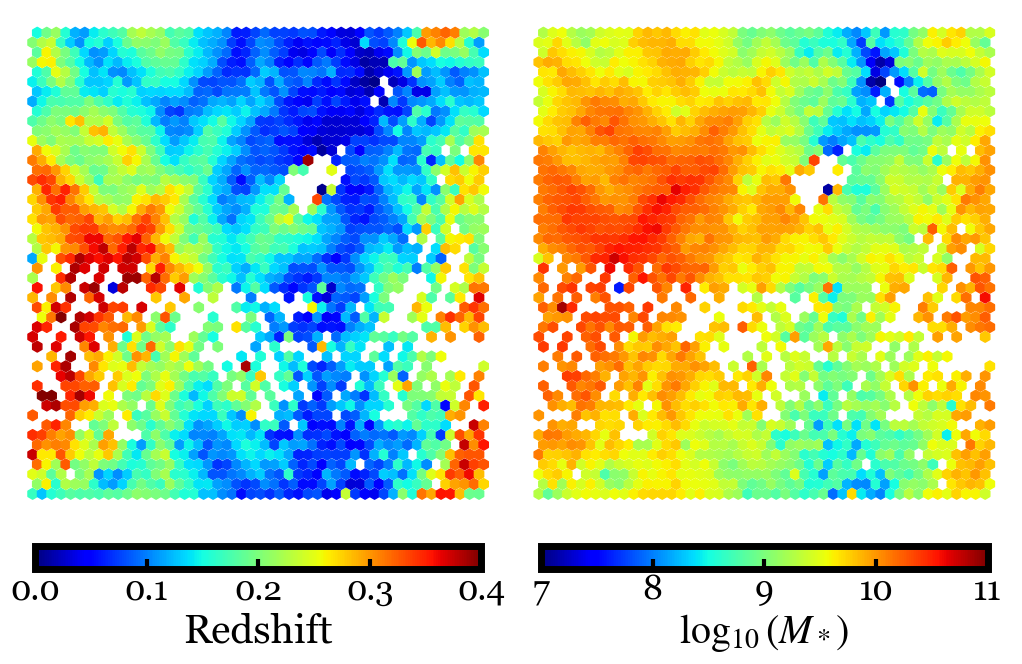

In [44]:
#Visualize labeled SOM
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                      np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)

for i in range(2):
    ax = fig.add_subplot(1, 5, i + 1)

    if i == 0:
        vmin = 0; vmax = 0.4
    if i == 1:
        vmin = 7; vmax = 11
    map = ax.scatter(*hexmesh, c = labeled_map[..., i], marker = 'h', cmap = 'jet', s = 60,
                     vmin = vmin, vmax = vmax)
    ax.axis('off')
    fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = ['Redshift', '$\log_{10}(M_*)$'][i], shrink = 0.9)

fig.savefig('/Users/leo/Projects/senior_thesis/labeled_SOM.pdf', dpi = 150, bbox_inches = 'tight')